<a href="https://colab.research.google.com/github/DevMazaro/mall-customer-segmentation/blob/main/mall_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mall Customer Segmentation with clustering**

##**Introduction**
This notebook exemplifies customer segmentation using
multiple clustering techniques, including K-Means, Hierarchical Clustering, and DBSCAN.
The analysis aims to identify distinct customer segments and provide actionable business insights.

Note: This uses the Mall Customer dataset, which is a commonly used dataset in data science
education and Kaggle competitions.

This analysis extends beyond just clustering to provide
detailed business recommendations. The goal is to demonstrate how data can be used to guide strategic decisions rather than simply confirm pre formed ideas.

In [1]:
#Importing libraries to be used in this project

#Data manipulation and analysis
import pandas as pd
import numpy as np

#Popular data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import fcluster
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

#Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

In [2]:
#--- Load Data ---
# Load the dataset from the file
# Loading the data directly from the github repo
# When cloning the project, uncomment the line below (and comment the next) to load from the local data folder

# data = pd.read_csv('data/Mall_Customers.csv')

data = pd.read_csv('https://raw.githubusercontent.com/DevMazaro/mall-customer-segmentation/refs/heads/main/data/Mall_Customers.csv')

# --- Basic Data Exploration and Analysis ---
print("\n--- Data Exploration and Analysis ---\n")

# Basic information about the dataset
print("Dataset Information:")
print(f"Shape: {data.shape}")
print("\nFirst few rows:")
print(data.head(10))

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Statistical summary of numerical features
print("\nStatistical Summary:")
print(data.describe())

# Distribution of categorical variables
print("\nGender Distribution:")
gender_counts = data['Gender'].value_counts()
print(gender_counts)
print(f"Percentage: {gender_counts / len(data) * 100}")


--- Data Exploration and Analysis ---

Dataset Information:
Shape: (200, 5)

First few rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72

Missing Values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)      

##**Data Exploration**
Before jumping into clustering analysis, let's explore our dataset to understand the distribution of variables and relationships between features. This will help us make informed decisions about feature selection and clustering approaches.

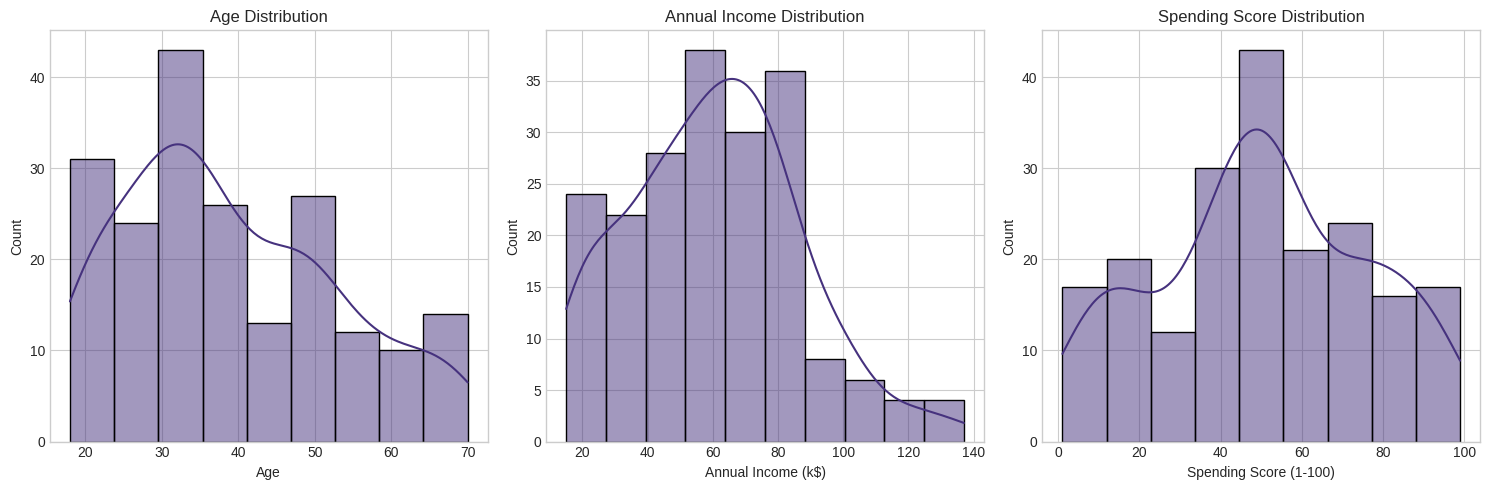

In [3]:
# Doing some data visualization
plt.figure(figsize=(15, 5))

# Age distribution
plt.subplot(1, 3, 1)
sns.histplot(data['Age'], kde=True)
plt.title('Age Distribution')

# Annual Income distribution
plt.subplot(1, 3, 2)
sns.histplot(data['Annual Income (k$)'], kde=True)
plt.title('Annual Income Distribution')

# Spending Score distribution
plt.subplot(1, 3, 3)
sns.histplot(data['Spending Score (1-100)'], kde=True)
plt.title('Spending Score Distribution')

plt.tight_layout()
plt.show()

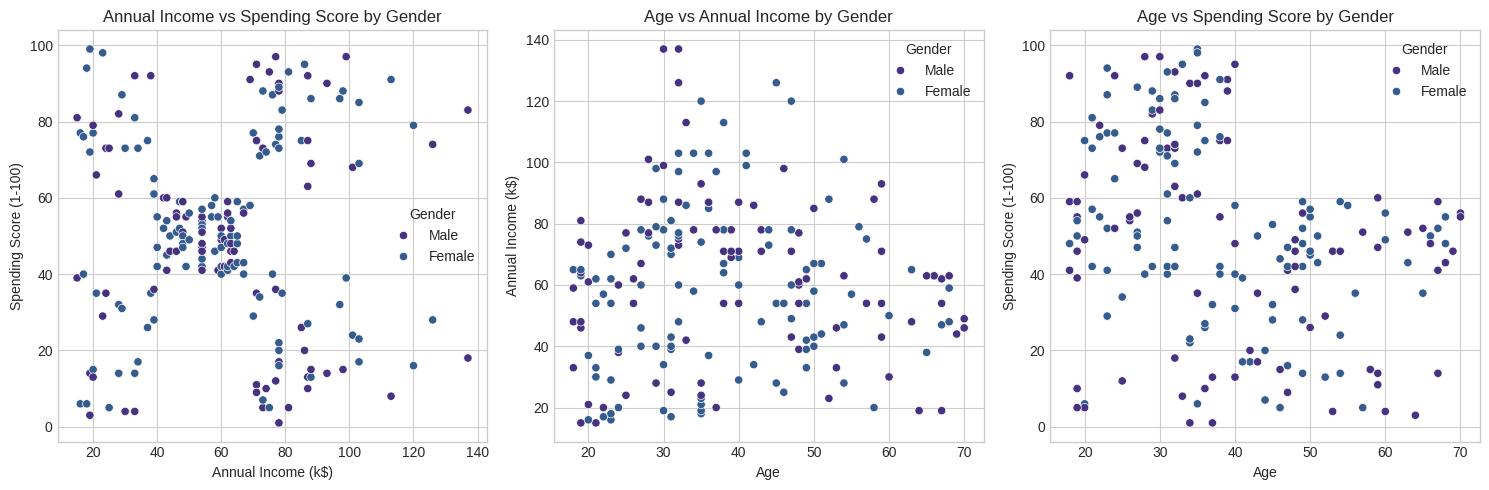

In [4]:
# Any relationthip in the data?
plt.figure(figsize=(15, 5))

# Relationship between Annual Income and Spending Score
plt.subplot(1, 3, 1)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=data, hue='Gender')
plt.title('Annual Income vs Spending Score by Gender')

# Age vs Annual Income
plt.subplot(1, 3, 2)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=data, hue='Gender')
plt.title('Age vs Annual Income by Gender')

# Age vs Spending Score
plt.subplot(1, 3, 3)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=data, hue='Gender')
plt.title('Age vs Spending Score by Gender')

plt.tight_layout()
plt.show()

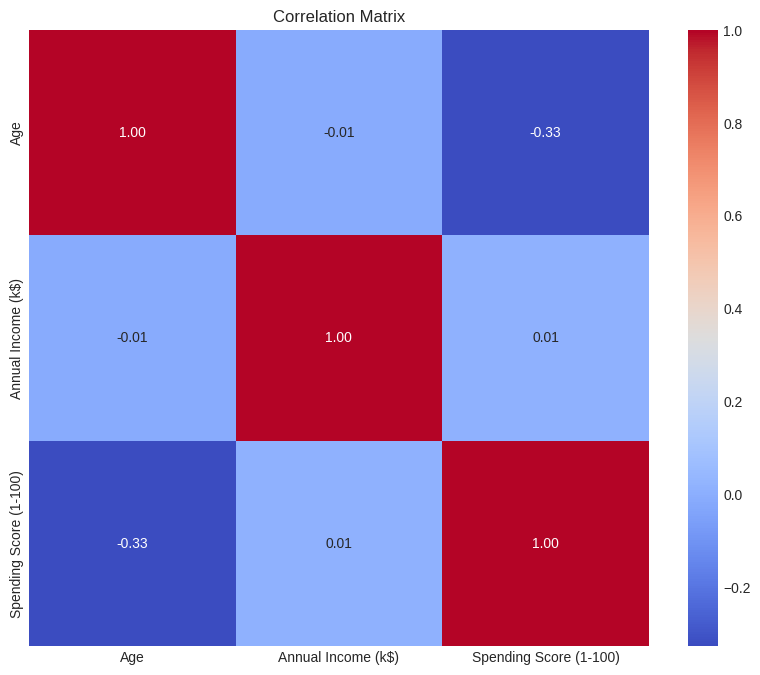

In [5]:
# Look for correlations between numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

##**Insights from Data Analysis (Before clustering)**
* **Statistical data and Feature Distributions**
   * **Age:**
      * This dataset has data points from 18 to 70, but the highest concentration is on the "I'm still young" crowd (30 to 40 years)
   * **Income:**
      * Large range of data (15K to 137K), but no extreme outliers. We will still scale the data for clustering.
      * Concentration on the 20K to 80K range, with a sharp drop after 80K
   * **Spending Score:**
      * Highest concentration right at the middle (50 points), but also has peaks around 20 points and 70-80 points. Perhaps there are 3 main kinds of customers (We will test that).
* Scatter Plots:
   * **Income vs. Spending Score:**
      * This scatter plot alone almost shows 5 different clusters. This suggest these two features will be good for clustering.
      * The scatter plot shows no correlation between income and spending score.
   * **Income vs Age:**
      * We see no clear relationship between income and age
   * **Age vs. Spending score**
       * Shows somewhat of a relationship with customer under 40 having a higher spending score that people older than 40.
       * Also displays clustering potential, but not nearly as clear as Income vs. Spending Score.
   * **Gender Analysis:**
      * Dataset relatively well balanced (56% female, 44% male)
      * The scatter plots show no indication of a clear separation between male and female.

##**Customer Segmentation with K-Means Clustering**
Clustering is an unsupervised machine learning technique that groups similar data points together without predefined labels. The goal is to find natural patterns in customer behavior that can inform business strategies. By identifying distinct customer segments, businesses can tailor their marketing, product offerings, and customer experience to better serve different groups.

<br>

K-Means is one of the most popular clustering algorithms due to its simplicity and effectiveness. It works by dividing data into k clusters, where each point belongs to the cluster with the nearest center (centroid). The algorithm iteratively adjusts these centroids until it finds the optimal grouping. Based on our exploration, Annual Income and Spending Score showed the clearest potential for natural groupings, making them ideal features for our initial clustering approach.

In [6]:
# Select features for clustering based on exploration insights
selected_features = data[['Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_features)

# Apply K-Means clustering with 5 clusters
# (We'll validate this number in the next section)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

print(f"K-Means clustering completed with {num_clusters} clusters")
print(f"Cluster distribution:\n{data['Cluster'].value_counts().sort_index()}")

K-Means clustering completed with 5 clusters
Cluster distribution:
Cluster
0    81
1    39
2    22
3    35
4    23
Name: count, dtype: int64


##**Finding the Optimal Number of Clusters**
Before settling on our cluster count, we need to validate that 5 clusters is actually optimal. Two key methods help us determine this: the Elbow Method and Silhouette Score.

*   **Elbow Method:** This technique plots the within-cluster sum of squares (WCSS) against different numbers of clusters. We look for the "elbow" (the point where adding more clusters doesn't significantly reduce WCSS).

*   **Silhouette Score:** This measures how well-separated our clusters are by comparing distances within clusters versus distances between clusters. Scores range from -1 to +1, where higher values indicate better-defined clusters. A score near +1 means points are close to their own cluster and far from others, while negative scores suggest points might be in the wrong cluster.

Using both methods together gives us confidence in our cluster count choice, ensuring we're not over-segmenting or missing important customer groups.

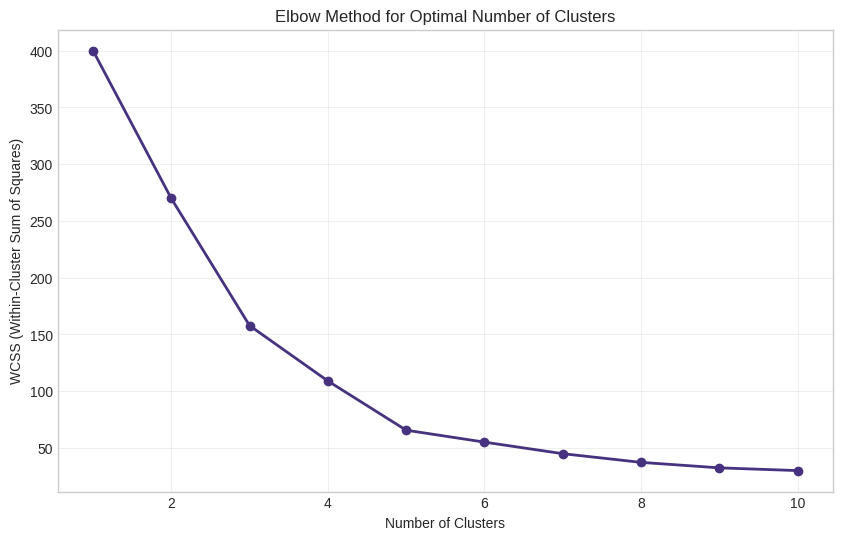

In [7]:
# Elbow Method - Calculate WCSS for different cluster numbers
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linewidth=2)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True, alpha=0.3)
plt.show()

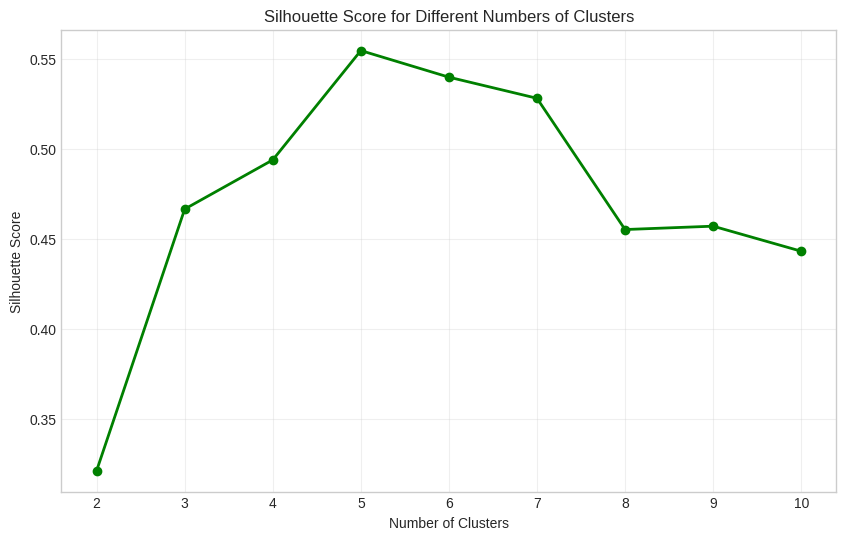

In [8]:
# Silhouette Score Analysis
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linewidth=2, color='green')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)
plt.show()

#### **Conclusion:**Both the elbow method and silhouette score indicate that 5 clusters is the optimal number of clusters

##**Visualizing Customer Segments**
Now let's see our clusters in action! The scatter plot below shows how K-Means has divided our customers into 5 distinct segments based on their income and spending patterns. The red X marks show the centroids (centers) of each cluster.

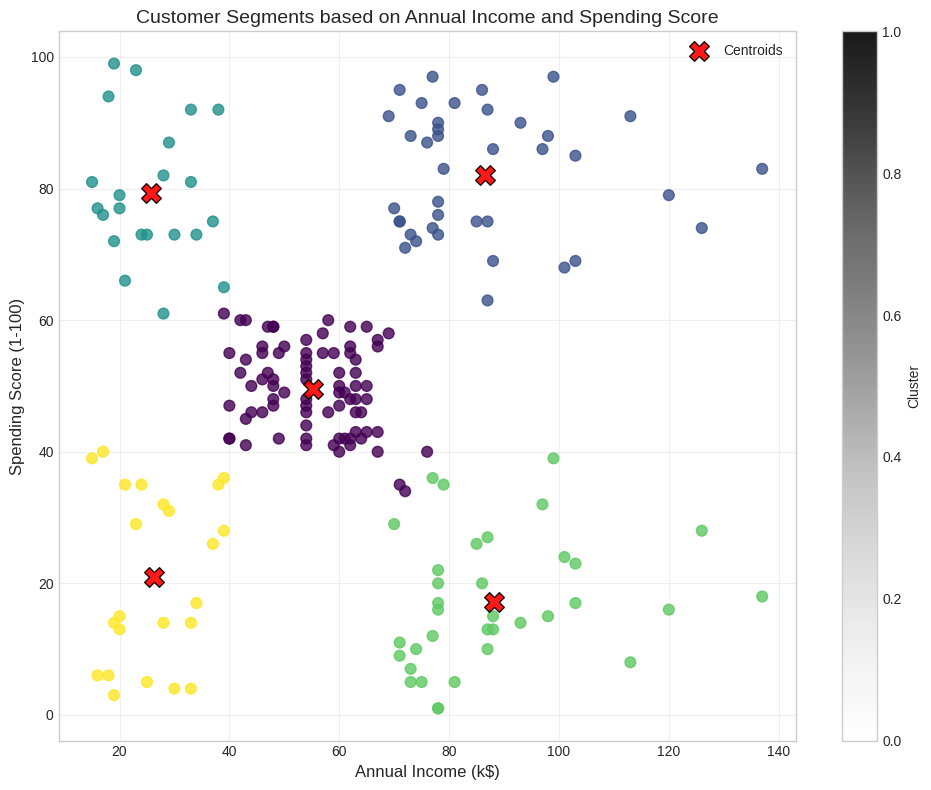

In [9]:
#Refiting the model to 5 clusters
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize the K-Means clustering results
plt.figure(figsize=(10, 8))
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
            c=data['Cluster'], cmap='viridis', s=60, alpha=0.8)

# Plot the centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.9,
           marker='X', label='Centroids', edgecolors='black', linewidth=1)

plt.title('Customer Segments based on Annual Income and Spending Score', fontsize=14)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.colorbar(label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
#Looking into the statistics of the clusters
cluster_analysis = data.groupby('Cluster').agg({
    'Annual Income (k$)': ['mean', 'min', 'max', 'count'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Age': 'mean',
    'Gender': lambda x: x.value_counts().to_dict()
}).round(2)

print("Cluster Analysis:")
print(cluster_analysis)

Cluster Analysis:
        Annual Income (k$)                Spending Score (1-100)          \
                      mean min  max count                   mean min max   
Cluster                                                                    
0                    55.30  39   76    81                  49.52  34  61   
1                    86.54  69  137    39                  82.13  63  97   
2                    25.73  15   39    22                  79.36  61  99   
3                    88.20  70  137    35                  17.11   1  39   
4                    26.30  15   39    23                  20.91   3  40   

           Age                      Gender  
          mean                    <lambda>  
Cluster                                     
0        42.72  {'Female': 48, 'Male': 33}  
1        32.69  {'Female': 21, 'Male': 18}  
2        25.27   {'Female': 13, 'Male': 9}  
3        41.11  {'Male': 19, 'Female': 16}  
4        45.22   {'Female': 14, 'Male': 9}  


##**Hierarchical Clustering Analysis**
Let's compare our K-Means results with hierarchical clustering, which builds clusters by progressively merging or splitting groups based on similarity. Unlike K-Means, hierarchical clustering doesn't require us to specify the number of clusters upfront - we can visualize the entire clustering process through a dendrogram and then decide where to "cut" the tree to get our desired number of clusters.

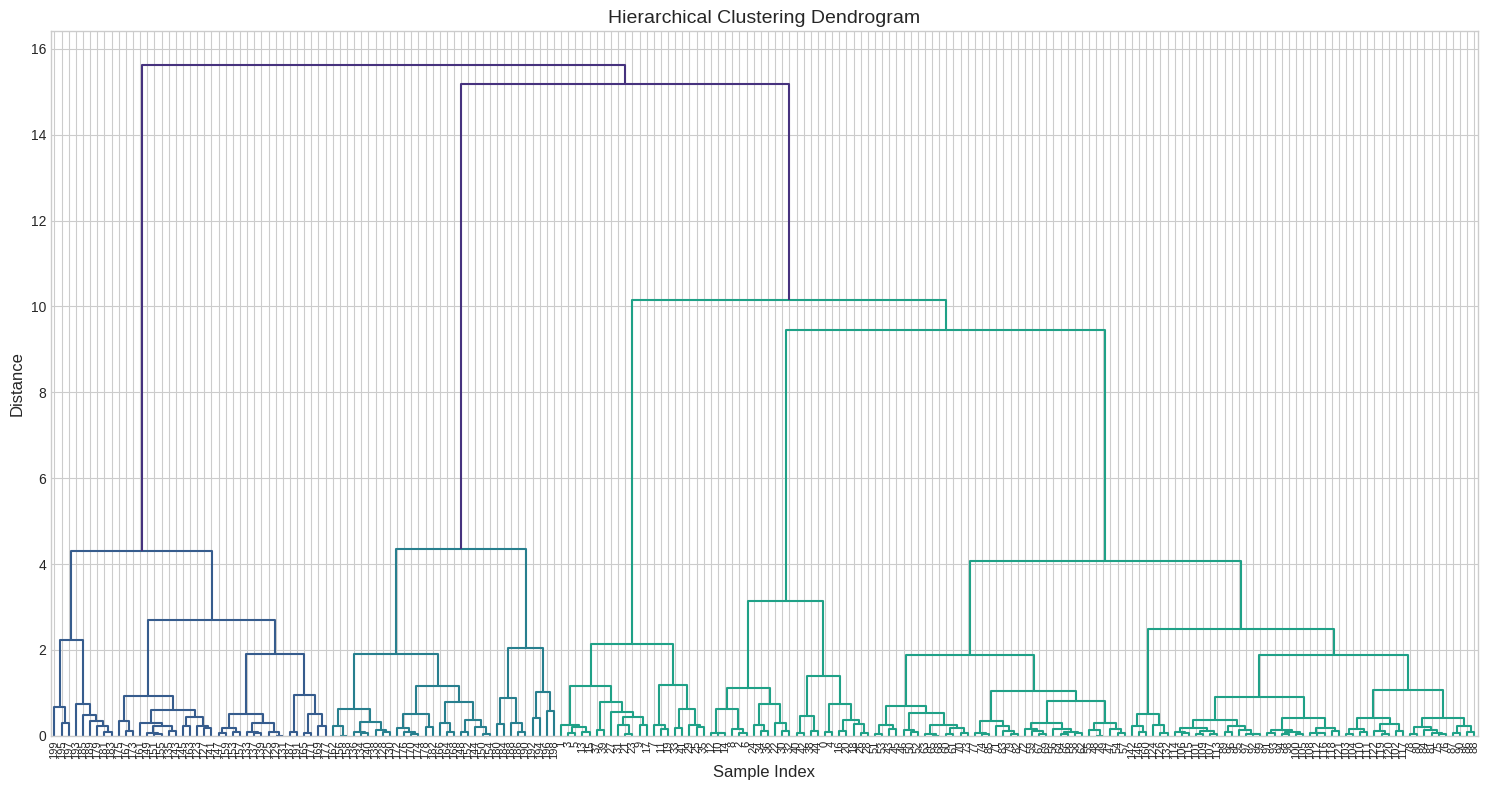

In [11]:
# Perform hierarchical clustering using Ward linkage
Z = linkage(scaled_data, 'ward')

# Create a dendrogram to visualize the hierarchical structure
plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)

# Draw the dendrogram
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)

plt.tight_layout()
plt.show()

##**Creating Hierarchical Clusters**
Based on the dendrogram, we can see natural break points where clusters merge. Let's cut the tree at a distance that gives us 5 clusters to match our K-Means analysis.

In [12]:
# Cut the dendrogram to create 5 clusters
threshold = 4.5
hierarchical_clusters = fcluster(Z, threshold, criterion='distance')

# Add the cluster labels to the dataframe
data['Hierarchical_Cluster'] = hierarchical_clusters

print(f"Hierarchical clustering completed with {len(set(hierarchical_clusters))} clusters")
print(f"Cluster distribution:\n{pd.Series(hierarchical_clusters).value_counts().sort_index()}")

Hierarchical clustering completed with 5 clusters
Cluster distribution:
1    39
2    32
3    21
4    23
5    85
Name: count, dtype: int64


##**Hierarchical Clustering Results**
Now let's examine how hierarchical clustering has segmented our customers and analyze the cluster characteristics.

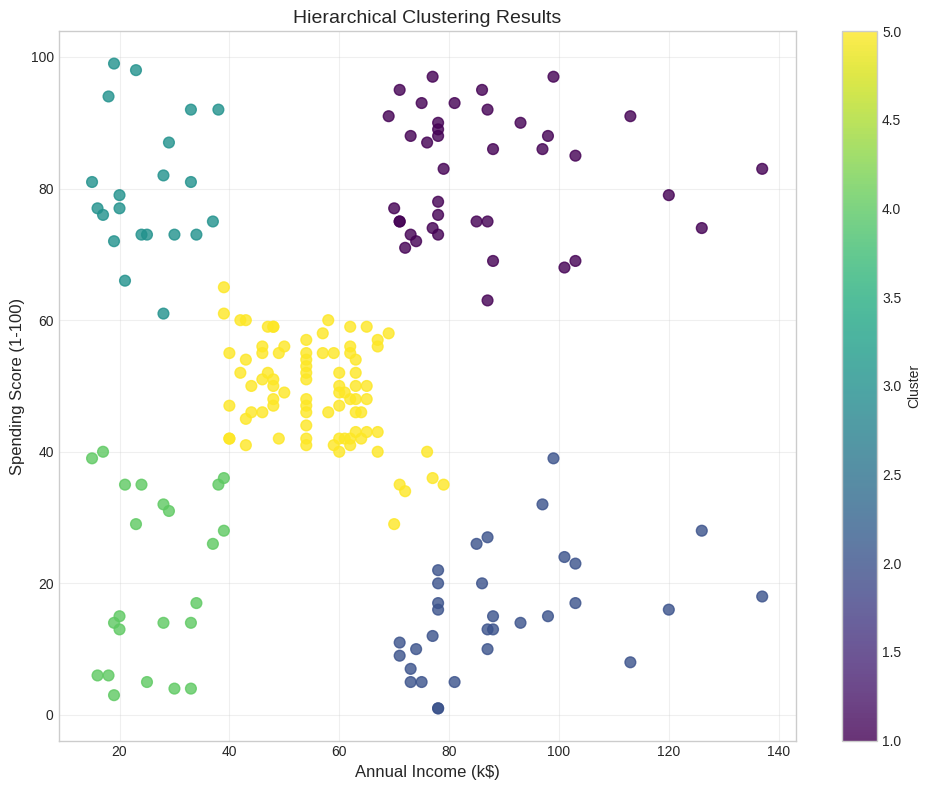

In [13]:
# Visualize hierarchical clustering results
plt.figure(figsize=(10, 8))
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
            c=data['Hierarchical_Cluster'], cmap='viridis', s=60, alpha=0.8)

plt.title('Hierarchical Clustering Results', fontsize=14)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Analyze hierarchical clustering results
hierarchical_analysis = data.groupby('Hierarchical_Cluster').agg({
    'Annual Income (k$)': ['mean', 'min', 'max', 'count'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Age': 'mean',
    'Gender': lambda x: x.value_counts().to_dict()
}).round(2)

print("Hierarchical Clustering Analysis:")
print(hierarchical_analysis)

Hierarchical Clustering Analysis:
                     Annual Income (k$)                Spending Score (1-100)  \
                                   mean min  max count                   mean   
Hierarchical_Cluster                                                            
1                                 86.54  69  137    39                  82.13   
2                                 89.41  71  137    32                  15.59   
3                                 25.10  15   38    21                  80.05   
4                                 26.30  15   39    23                  20.91   
5                                 55.81  39   79    85                  49.13   

                                Age                      Gender  
                     min max   mean                    <lambda>  
Hierarchical_Cluster                                             
1                     63  97  32.69  {'Female': 21, 'Male': 18}  
2                      1  39  41.00  {'Male': 18, 'Fe

##**DBSCAN Clustering Analysis**
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) takes a different approach from K-Means and Hierarchical clustering. Instead of forcing every point into a cluster, DBSCAN identifies dense regions and can classify some points as "noise" or outliers. This makes it particularly useful for finding clusters of varying shapes and identifying customers who don't fit typical patterns. DBSCAN requires two key parameters: eps (the maximum distance between points in the same neighborhood) and min_samples (the minimum number of points needed to form a cluster core).

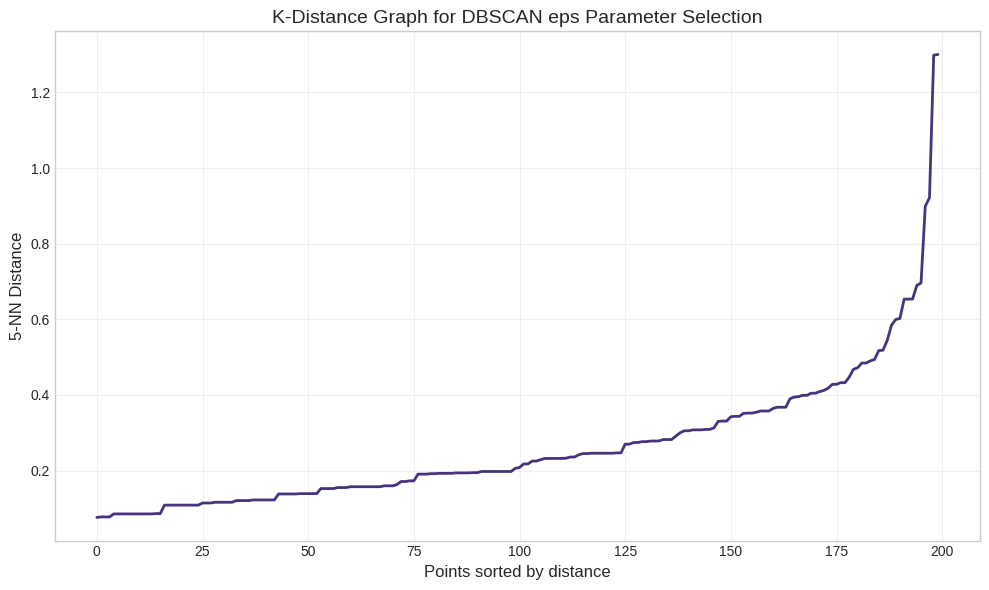

In [15]:
# Find optimal eps parameter using k-distance graph
# We'll look for the "elbow" point where distance increases sharply
k = 5  # Typically k = min_samples for DBSCAN
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(scaled_data)
distances, indices = neigh.kneighbors(scaled_data)

# Sort distances to k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph to identify optimal eps
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances, linewidth=2)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'{k}-NN Distance', fontsize=12)
plt.title('K-Distance Graph for DBSCAN eps Parameter Selection', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##**Applying DBSCAN with Optimal Parameters**
Based on the k-distance graph, we can identify the optimal eps value where the distance curve shows a sharp increase (the "elbow" point).

In [16]:
# Apply DBSCAN with parameters identified from k-distance graph
eps = 0.40  # Distance threshold based on elbow in k-distance plot
min_samples = 5  # Minimum number of points to form a dense region

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
data['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_data)

# Count clusters and noise points
n_clusters = len(set(data['DBSCAN_Cluster'])) - (1 if -1 in data['DBSCAN_Cluster'] else 0)
n_noise = list(data['DBSCAN_Cluster']).count(-1)

print(f'Number of DBSCAN clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')
print(f'DBSCAN cluster distribution:\n{data["DBSCAN_Cluster"].value_counts().sort_index()}')

Number of DBSCAN clusters: 5
Number of noise points: 15
DBSCAN cluster distribution:
DBSCAN_Cluster
-1     15
 0    115
 1     11
 2     32
 3     27
Name: count, dtype: int64


##**DBSCAN Results Visualization**
Let's visualize how DBSCAN has segmented our customers. Notice that DBSCAN can identify outliers as "noise" points (shown in gray), which represents customers with unusual spending patterns.

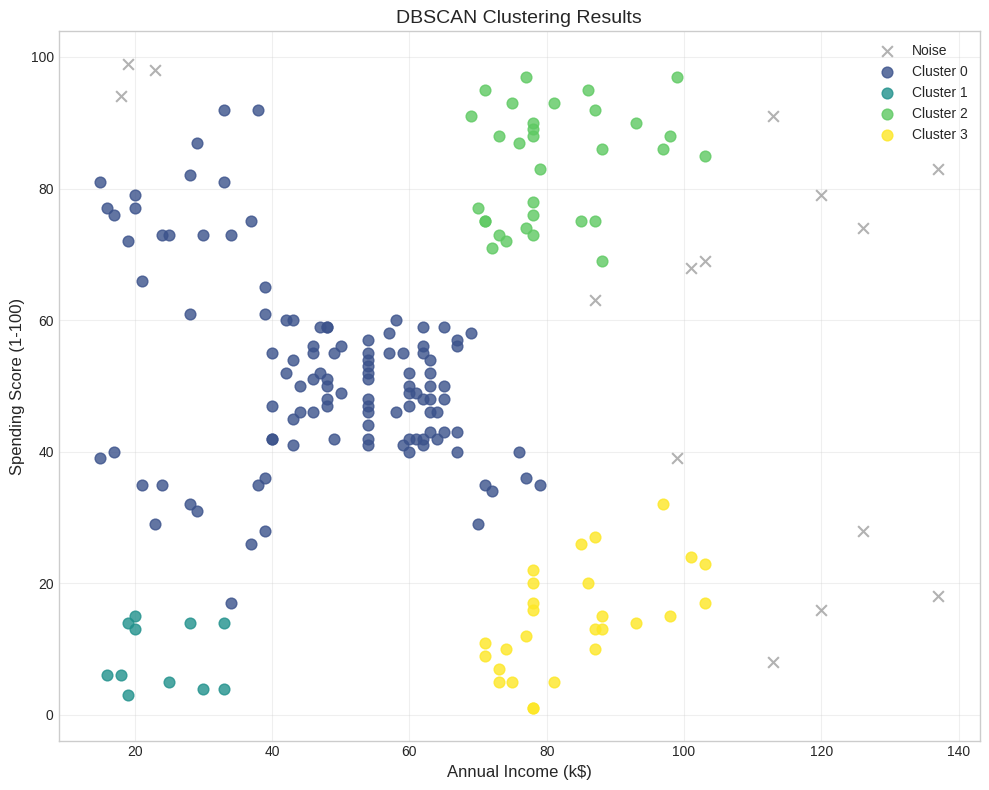

In [17]:
# Visualize DBSCAN clustering results
plt.figure(figsize=(10, 8))

# Plot each cluster with different colors
unique_clusters = sorted(set(data['DBSCAN_Cluster']))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

for i, cluster in enumerate(unique_clusters):
    cluster_data = data[data['DBSCAN_Cluster'] == cluster]

    if cluster == -1:  # Noise points
        plt.scatter(cluster_data['Annual Income (k$)'],
                   cluster_data['Spending Score (1-100)'],
                   c='gray', label='Noise', s=60, alpha=0.6, marker='x')
    else:  # Regular clusters
        plt.scatter(cluster_data['Annual Income (k$)'],
                   cluster_data['Spending Score (1-100)'],
                   c=[colors[i]], label=f'Cluster {cluster}', s=60, alpha=0.8)

plt.title('DBSCAN Clustering Results', fontsize=14)
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Analyze DBSCAN cluster characteristics
dbscan_analysis = data.groupby('DBSCAN_Cluster').agg({
    'Annual Income (k$)': ['mean', 'min', 'max', 'count'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Age': 'mean',
    'Gender': lambda x: x.value_counts().to_dict()
}).round(2)

print("DBSCAN Cluster Analysis:")
print(dbscan_analysis)

DBSCAN Cluster Analysis:
               Annual Income (k$)                Spending Score (1-100)      \
                             mean min  max count                   mean min   
DBSCAN_Cluster                                                                
-1                          96.13  18  137    15                  61.80   8   
 0                          48.30  15   79   115                  51.73  17   
 1                          23.73  16   33    11                   8.91   3   
 2                          80.88  69  103    32                  83.62  69   
 3                          83.93  71  103    27                  14.44   1   

                      Age                      Gender  
               max   mean                    <lambda>  
DBSCAN_Cluster                                         
-1              99  34.53    {'Female': 9, 'Male': 6}  
 0              92  39.54  {'Female': 68, 'Male': 47}  
 1              15  49.36    {'Female': 6, 'Male': 5}  
 2    

##**Comparing All Three Clustering Methods**
Now let's examine how K-Means, Hierarchical Clustering, and DBSCAN have segmented our customers. We'll compare their statistical summaries and visualize all three approaches side-by-side to understand their differences and strengths.

In [19]:
# Compare statistics across all three clustering methods
print("=== K-MEANS CLUSTERING ANALYSIS ===")
kmeans_analysis = data.groupby('Cluster').agg({
    'Annual Income (k$)': ['mean', 'min', 'max', 'count'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Age': 'mean',
    'Gender': lambda x: x.value_counts().to_dict()
}).round(2)
print(kmeans_analysis)

print("\n=== HIERARCHICAL CLUSTERING ANALYSIS ===")
hierarchical_analysis = data.groupby('Hierarchical_Cluster').agg({
    'Annual Income (k$)': ['mean', 'min', 'max', 'count'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Age': 'mean',
    'Gender': lambda x: x.value_counts().to_dict()
}).round(2)
print(hierarchical_analysis)

print("\n=== DBSCAN CLUSTERING ANALYSIS ===")
dbscan_analysis = data.groupby('DBSCAN_Cluster').agg({
    'Annual Income (k$)': ['mean', 'min', 'max', 'count'],
    'Spending Score (1-100)': ['mean', 'min', 'max'],
    'Age': 'mean',
    'Gender': lambda x: x.value_counts().to_dict()
}).round(2)
print(dbscan_analysis)

=== K-MEANS CLUSTERING ANALYSIS ===
        Annual Income (k$)                Spending Score (1-100)          \
                      mean min  max count                   mean min max   
Cluster                                                                    
0                    55.30  39   76    81                  49.52  34  61   
1                    86.54  69  137    39                  82.13  63  97   
2                    25.73  15   39    22                  79.36  61  99   
3                    88.20  70  137    35                  17.11   1  39   
4                    26.30  15   39    23                  20.91   3  40   

           Age                      Gender  
          mean                    <lambda>  
Cluster                                     
0        42.72  {'Female': 48, 'Male': 33}  
1        32.69  {'Female': 21, 'Male': 18}  
2        25.27   {'Female': 13, 'Male': 9}  
3        41.11  {'Male': 19, 'Female': 16}  
4        45.22   {'Female': 14, 'Male': 

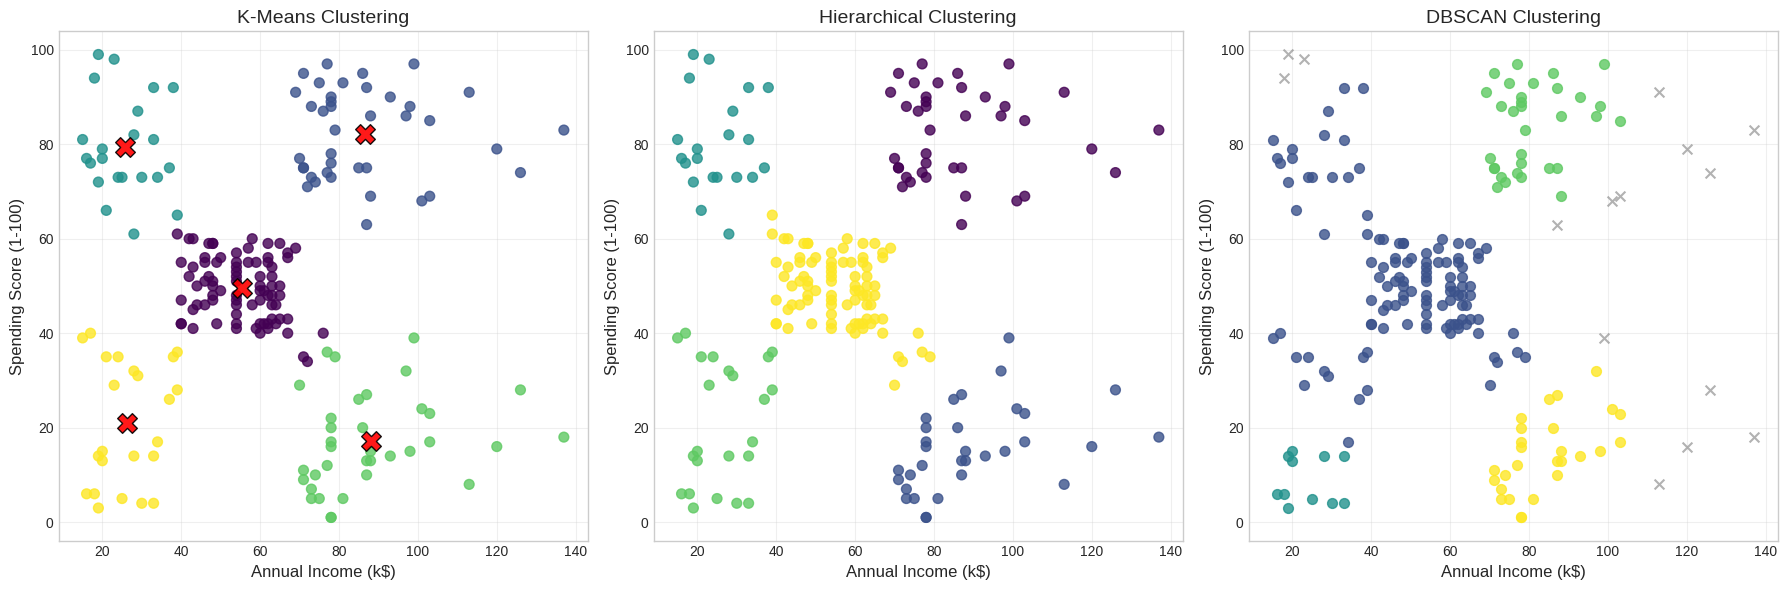

In [20]:
# Visualize all three clustering methods side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Means Plot
axes[0].scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
                c=data['Cluster'], cmap='viridis', s=50, alpha=0.8)
axes[0].scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.9,
                marker='X', edgecolors='black', linewidth=1)
axes[0].set_title('K-Means Clustering', fontsize=14)
axes[0].set_xlabel('Annual Income (k$)', fontsize=12)
axes[0].set_ylabel('Spending Score (1-100)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Hierarchical Plot
axes[1].scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
                c=data['Hierarchical_Cluster'], cmap='viridis', s=50, alpha=0.8)
axes[1].set_title('Hierarchical Clustering', fontsize=14)
axes[1].set_xlabel('Annual Income (k$)', fontsize=12)
axes[1].set_ylabel('Spending Score (1-100)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# DBSCAN Plot
unique_clusters = sorted(set(data['DBSCAN_Cluster']))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

for i, cluster in enumerate(unique_clusters):
    cluster_data = data[data['DBSCAN_Cluster'] == cluster]

    if cluster == -1:  # Noise points
        axes[2].scatter(cluster_data['Annual Income (k$)'],
                       cluster_data['Spending Score (1-100)'],
                       c='gray', s=50, alpha=0.6, marker='x')
    else:  # Regular clusters
        axes[2].scatter(cluster_data['Annual Income (k$)'],
                       cluster_data['Spending Score (1-100)'],
                       c=[colors[i]], s=50, alpha=0.8)

axes[2].set_title('DBSCAN Clustering', fontsize=14)
axes[2].set_xlabel('Annual Income (k$)', fontsize=12)
axes[2].set_ylabel('Spending Score (1-100)', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **Clustering Methods Comparison and Customer Segment Analysis**

Our comprehensive analysis of three clustering techniques reveals distinct strengths and applications for customer segmentation. K-Means and Hierarchical clustering produced remarkably similar results, identifying virtually identical customer segments with only minimal differences in cluster boundaries. This convergence validates the natural groupings present in our customer data and provides confidence in our segmentation approach.

## K-Means vs Hierarchical Clustering: Strong Convergence

Both methods successfully identified five distinct customer segments with nearly identical characteristics. The slight variations in cluster membership (typically 1-4 customers per segment) demonstrate the robustness of these natural groupings. K-Means provided cleaner, more balanced clusters due to its optimization of within-cluster variance, while Hierarchical clustering offered insights into the natural merger process through its dendrogram visualization.

<br>

| K-means Cluster | Hierarchical Cluster | Customer Segment Description |
| --- | --- | --- |
| Cluster 0 | Cluster 5 | Middle-income, Moderate spenders |
| Cluster 1 | Cluster 1 | High-income, High spenders |
| Cluster 2 | Cluster 3 | Low-income, High spenders |
| Cluster 3 | Cluster 2 | High-income, Low spenders |
| Cluster 4 | Cluster 4 | Low-income, Low spenders |

<br>

## DBSCAN Analysis: Limitations for This Dataset

While DBSCAN excels at finding clusters with irregular shapes and varying densities, our analysis revealed significant limitations for this particular customer dataset. DBSCAN's density-based approach suffered from chaining effects where data points created bridges between distinct customer groups, leading to cluster overgrowth and inappropriate mergers. The algorithm's parameter sensitivity made it challenging to achieve optimal segmentation - reducing eps created excessive noise points, while increasing it merged clearly separate customer segments. For our structured, well-separated customer data, K-Means proved superior in creating meaningful, actionable segments.

# **Customer Segment Analysis Using K-Means Results**

## Segment 1 - Standard Shoppers (Cluster 0): The Foundation

**Statistical Characteristics:**
- Size: 81 customers (40.5% of customer base)
- Average age: 42.72 years
- Gender distribution: 59% female, 41% male
- Income range: \$39k-\$76k (average: \$55,300)
- Spending score range: 34-61 (average: 49.52)

**Customer Profile:** This largest segment represents typical mall customers with moderate income and balanced spending patterns. These customers are generally middle-aged and include more women than men. They exhibit consistent but controlled spending behavior, likely making regular purchases without excessive splurging.

**Strategic Implications:** As the largest customer segment, these shoppers form the backbone of the mall's revenue. They respond well to:
- Value-based offerings and loyalty programs
- Mid-range price points
- Cross-promotional campaigns across various store types
- Seasonal marketing initiatives

### Segment 2 - Premium Shoppers (Cluster 1): The Revenue Drivers

**Statistical Characteristics:**
- Size: 39 customers (19.5% of customer base)
- Average age: 32.69 years (youngest affluent group)
- Gender distribution: Nearly balanced (54% female, 46% male)
- Income range: \$69k-\$137k (average: \$86,540)
- Spending score range: 63-97 (average: 82.13)

**Customer Profile:** These younger affluent professionals combine high income with high spending propensity. They represent the mall's most valuable customer segment, with both the means and desire to spend generously. Their balanced gender ratio suggests this segment includes young professionals and possibly DINKs (Double Income, No Kids).

**Strategic Implications:** This segment should be the primary target for premium offerings:
- Premium brands and luxury services
- High-end promotions and exclusive events
- Quality-focused and brand prestige marketing
- Exceptional shopping experiences
- Despite being only 19.5% of customers, they likely contribute disproportionately to revenue and profit

### Segment 3 - Fashion-Forward Youth (Cluster 2): High Potential Despite Budget Constraints

**Statistical Characteristics:**
- Size: 22 customers (11% of customer base)
- Average age: 25.27 years (youngest overall group)
- Gender distribution: 59% female, 41% male
- Income range: \$15k-\$39k (average: \$25,730)
- Spending score range: 61-99 (average: 79.36)

**Customer Profile:** Despite having the lowest income among all segments, these young shoppers maintain high spending scores. They represent trend-conscious consumers who prioritize shopping despite budget constraints, likely allocating a high percentage of their disposable income to mall purchases. This group might include students and entry-level workers who place high value on fashion and social shopping experiences.

**Strategic Implications:** This segment responds well to youth-oriented strategies:
- Trendy, affordable fashion options
- Social media marketing campaigns
- Budget-friendly versions of current trends
- Installment payment options and student discounts
- Flash sales and limited-time offers
- High long-term value as earning power increases

### Segment 4 - Affluent Conservatives (Cluster 3): The Opportunity Gap

**Statistical Characteristics:**
- Size: 35 customers (17.5% of customer base)
- Average age: 41.11 years
- Gender distribution: 54% male, 46% female
- Income range: \$70k-\$137k (average: \$88,200)
- Spending score range: 1-39 (average: 17.11)

**Customer Profile:** With the highest average income but lowest spending scores, these customers are financially able but unwilling to spend at the mall. This middle-aged group has more men than women and represents value-conscious shoppers who likely make deliberate, researched purchases. They may visit the mall infrequently or for very specific purchases only.

**Strategic Implications:** This segment represents significant untapped potential:
- Rational appeals emphasizing value, quality, and durability
- Investment pieces and premium services
- Exclusive events and personalized shopping experiences
- Evidence-based marketing highlighting product benefits
- Focus on converting high-income, low-engagement customers

### Segment 5 - Budget Conservatives (Cluster 4): The Practical Shoppers

**Statistical Characteristics:**
- Size: 23 customers (11.5% of customer base)
- Average age: 45.22 years (oldest group)
- Gender distribution: 61% female, 39% male
- Income range: \$15k-\$39k (average: \$26,300)
- Spending score range: 3-40 (average: 20.91)

**Customer Profile:** This segment combines low income with low spending propensity. These older shoppers are likely on fixed or limited incomes and exhibit highly conservative spending behavior. They may visit the mall primarily for necessities, heavily discounted items, or specific essential purchases.

**Strategic Implications:** While not high-revenue generators, they respond to practical approaches:
- Budget-friendly offerings and substantial discounts
- Essential services and practical value propositions
- Clearance sales and necessity-focused marketing
- Purposeful, need-based shopping experiences

## Conclusion

K-Means clustering proved most effective for this customer segmentation analysis, providing clear, actionable insights into five distinct customer groups. Each segment requires tailored marketing strategies and service offerings to maximize customer satisfaction and business profitability. The convergence between K-Means and Hierarchical clustering validates these natural customer groupings, while DBSCAN's limitations highlight the importance of selecting appropriate clustering methods based on data characteristics and business objectives.

# Business Considerations and Implementation Strategies

## Customer Segment Implementation Strategies

### Segment-Specific Marketing Approaches

**Standard Shoppers (40.5% of customers):**
- Implement comprehensive loyalty program with tier benefits
- Focus on family-oriented promotions and seasonal campaigns
- Utilize email marketing with value-focused messaging
- Cross-promote complementary stores and services

**Premium Shoppers (19.5% of customers):**
- Create VIP shopping experiences and exclusive events
- Implement personal shopping services and concierge programs
- Partner with luxury brands for exclusive launches
- Offer premium parking and express checkout services

**Fashion-Forward Youth (11% of customers):**
- Develop strong social media presence and influencer partnerships
- Create Instagram-worthy spaces and photo opportunities
- Implement mobile-first marketing strategies
- Offer flexible payment options and student discounts

**Affluent Conservatives (17.5% of customers):**
- Focus on quality-driven, educational marketing content
- Offer detailed product information and expert consultations
- Implement targeted email campaigns emphasizing value and durability
- Create exclusive shopping hours for a more curated experience

**Budget Conservatives (11.5% of customers):**
- Limit marketing spend on this group
- Emphasize clearance events and promotional pricing
- Create early-bird shopping hours for best deals
- Focus on practical, necessity-based marketing
- Implement simple, straightforward communication strategies

## Operational Recommendations

### Store Mix and Layout Optimization
- **Premium Zone**: Dedicate premium mall spaces to high-end brands targeting Premium Shoppers and high-value Standard Shoppers
- **Youth Fashion Hub**: Create a concentrated area for trendy, affordable brands targeting Fashion-Forward Youth
- **Value Section**: Ensure adequate representation of discount and outlet stores for Budget Conservatives and price-sensitive segments
- **Mixed-Use Areas**: Design spaces that appeal to Standard Shoppers with diverse retail options

### Technology Integration
- **Mobile App Development**: Create segment-specific app experiences with personalized offers and navigation
- **Smart Parking**: Implement dynamic pricing and reserved spaces that reflect customer segments
- **Beacon Technology**: Send targeted notifications based on segment profiles and mall location
- **Customer Analytics Dashboard**: Track segment performance and shopping patterns in real-time

### Staff Training and Service Delivery
- **Segment Recognition Training**: Educate staff to identify and appropriately serve different customer segments
- **Service Level Differentiation**: Implement varying service approaches based on segment needs and expectations
- **Upselling Strategies**: Train staff on segment-appropriate cross-selling and upselling techniques

## Performance Measurement and Optimization

### Key Performance Indicators (KPIs) by Segment
**Revenue Metrics:**
- Revenue per customer by segment
- Average transaction value by segment
- Conversion rate from visits to purchases
- Segment-specific profit margins

**Engagement Metrics:**
- Visit frequency by segment
- Time spent in mall by segment
- Cross-store shopping behavior
- Loyalty program participation rates

**Marketing Effectiveness:**
- Campaign response rates by segment
- Cost per acquisition by segment
- Customer lifetime value by segment
- Digital engagement rates by segment

### A/B Testing Framework
- **Promotional Strategies**: Test different discount structures and promotional timing across segments
- **Communication Channels**: Compare email, SMS, social media, and in-mall advertising effectiveness
- **Service Approaches**: Test personalized vs. standardized service delivery for different segments
- **Product Mix**: Experiment with different store combinations and product offerings

## Long-term Strategic Considerations

### Segment Evolution Monitoring
- **Age Progression**: Track how Fashion-Forward Youth transition to other segments over time
- **Economic Changes**: Monitor how economic conditions affect segment behavior and size
- **Seasonal Variations**: Understand how segments behave differently across seasons and holidays
- **Competitive Response**: Analyze how segment preferences shift due to competitor actions

### Investment and Expansion Decisions
- **New Store Recruitment**: Use segment analysis to identify optimal new retailers and brands
- **Renovation Priorities**: Allocate capital improvements based on segment value and specific needs
- **Technology Investments**: Prioritize tech solutions that serve high-value segments most effectively
- **Marketing Budget Allocation**: Distribute marketing spend proportional to segment value and responsiveness

### Risk Management
- **Segment Concentration Risk**: Monitor over-dependence on any single customer segment for revenue
- **Economic Sensitivity**: Prepare contingency plans for economic downturns affecting different segments
- **Demographic Shifts**: Plan for changing community demographics and their impact on segment composition
- **Competitive Threats**: Develop retention strategies for high-value segments against competitive pressure
